In [1]:
!pip install -U nltk -qq
!pip install -U spacy -qq
!python -m spacy download en_core_web_sm -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 107.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
basepath = '/content/drive/MyDrive/data'
sys.path.append('/content/drive/MyDrive/Applied NLP/Codes/Custom py classes')

In [4]:
import pandas as pd
spam_df = pd.read_csv("/content/drive/MyDrive/Applied NLP/Codes/spam.csv", encoding='latin-1')
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
spam_df = spam_df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
spam_df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
spam_df["label"] = spam_df["label"].map({'ham': 0, 'spam': 1})

In [6]:
import sklearn
from sklearn.model_selection import train_test_split

(train_df, test_df) = train_test_split(spam_df, test_size=0.4, random_state=42)
X_train = train_df['message'].values
X_test = test_df['message'].values
y_train = train_df['label'].values
y_test = test_df['label'].values

**FINAL TRAINING**

In [7]:
import CustomPreprocessorSpacy as cp
from FeaturizerSpacy import ManualFeatures
from plot_learning_curve import plot_learning_curve

In [8]:
X_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 100).transform(X_train)

/content/drive/MyDrive/Applied NLP/Codes/Custom py classes/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [9]:
X_train_cleaned_features = cp.SpacyPreprocessor(model='en_core_web_sm',
                                                    lemmatize=False, lower=False,
                                                    remove_stop=False, remove_punct=False,
                                                    remove_email=False, remove_url=False,
                                                     add_user_mention_prefix=False,
                                                     basic_clean_only=True).transform(X_train)

In [10]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm', batch_size = 200)

In [11]:
X_train_features, feature_names = featurizer.fit_transform(X_train_cleaned_features)

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [12]:
X_train_final = pd.concat((pd.DataFrame(X_train_cleaned, columns=['cleaned_text']),
                           pd.DataFrame(X_train_features, columns=feature_names)), axis=1)

In [13]:
X_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_numbers,count_sentences,noun_count,aux_count,verb_count,adj_count,ner
0,need strong arm,9.0,37.0,29.0,2.900000,0.0,1.0,1.0,1.0,1.0,1.0,0.0
1,haha hear text,10.0,45.0,37.0,3.363636,0.0,1.0,0.0,1.0,2.0,0.0,0.0
2,love hear v sundayish,12.0,53.0,43.0,3.307692,0.0,1.0,1.0,1.0,3.0,1.0,0.0
3,pete phone jenny college,17.0,90.0,75.0,4.166667,0.0,2.0,3.0,2.0,0.0,1.0,2.0
4,u have dinner w,9.0,45.0,37.0,3.700000,0.0,1.0,1.0,0.0,3.0,0.0,0.0


In [14]:
from sklearn.base import TransformerMixin, BaseEstimator
from scipy.sparse import csr_matrix
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])

In [16]:
from sklearn.compose import ColumnTransformer
combined_features = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'cleaned_text'),
    ], remainder=sparse_features
)

In [17]:
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', LogisticRegression(max_iter=10000)),
                         ])

In [18]:
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000],
                           'classifier__C': [0.1, 1, 10]
                           }

In [19]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3,
                                 param_grid=param_grid_classifier_3,
                                 cv=5,scoring='f1')

In [20]:
grid_classifier_3.fit(X_train_final, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('combined_features',
                                        ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                                                     SparseTransformer())]),
                                                          transformers=[('tfidf',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5))]),
                                                                         'cleaned_text')])),
                                       ('classifier',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'combined_features__tfidf__tfidf__max_features': [500,
                                                                           1000,
                                                                           2000]},
             scoring='f1')

In [21]:
print(
    "Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.92

Best parameters:  {'classifier__C': 10, 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier', LogisticRegression(C=10, max_iter=10000))])


In [22]:
# let's check the train scores
print(grid_classifier_3.best_estimator_.score(X_train_final, y_train))

# let's check the cross validation score
print(grid_classifier_3.best_score_)

0.9970086748429554
0.9163725429136234


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

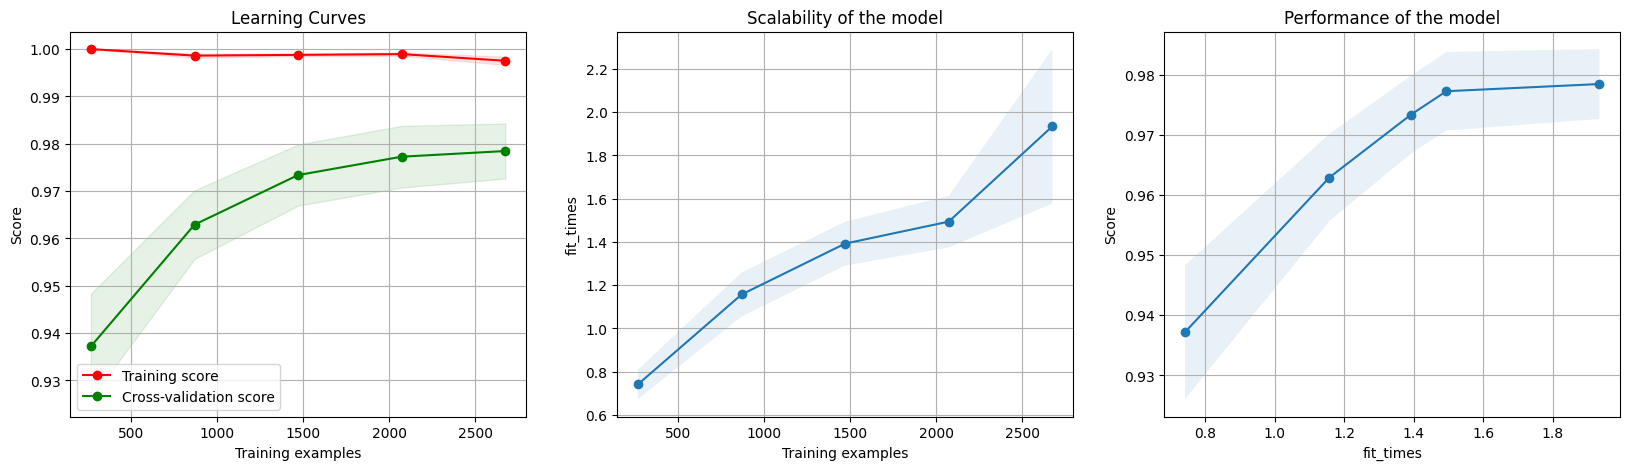

In [23]:
# plot learning curves
from plot_learning_curve import plot_learning_curve
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves',
                    X_train_final, y_train, n_jobs=-1)

In [24]:
def final_pipeline(text):
    cleaned_text = cp.SpacyPreprocessor(model='en_core_web_sm', batch_size = 200).transform(text)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = grid_classifier_3.best_estimator_
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions

In [25]:
y_test_pred = final_pipeline(X_test)

/content/drive/MyDrive/Applied NLP/Codes/Custom py classes/CustomPreprocessorSpacy.py:83: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [26]:
from sklearn.metrics import classification_report
print('\nTest set classification report:\n\n',
      classification_report(y_test, y_test_pred))


Test set classification report:

               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1930
           1       0.97      0.90      0.94       299

    accuracy                           0.98      2229
   macro avg       0.98      0.95      0.96      2229
weighted avg       0.98      0.98      0.98      2229



**As we can see this approach has resulted in a good F1-score suggesting that we have high precision and recall for the positive class.**